<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files%20/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Random Forest & Logistic Regression for Classification**


###**Library Imports and File Download :**

In [ ]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed  # For parallel processing
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


**numpy :** Used for mathematical operations and array manipulation.

**gdown :** Helps to download files from Google Drive.

**pandas :** Used for handling datasets in tabular form.

**matplotlib.pyplot :** Used for plotting graphs.

**seaborn :** Provides an aesthetic interface for visualizing data.

**sklearn.metrics :** Used to evaluate the performance of the model (confusion matrix, accuracy, precision, recall, F1-score).

**sklearn.model_selection.train_test_split :** Splits the dataset into training and testing sets.

**joblib :** Used for parallel processing to speed up computations.

**itertools.cycle :** Used for cycling through values in iterations.

**sklearn.preprocessing.label_binarize :** Converts labels into a binary matrix for multi-class classification.

**sklearn.linear_model.LogisticRegression :** Implements logistic regression for classification.

**sklearn.multiclass.OneVsRestClassifier :** Used for multi-class classification by training one model per class.



Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=e11792f7-2227-4c7d-8d2f-3a48aa9db25c
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:00<00:00, 209MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 97.3MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


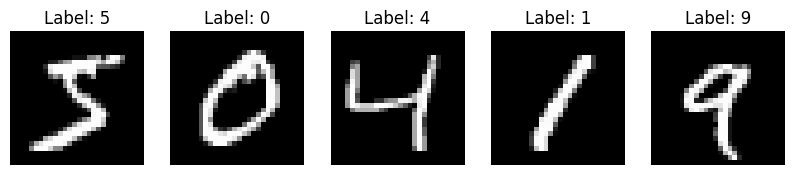

In [ ]:
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()


##**Entropy-based Decision Tree Construction and Prediction :**

In [ ]:
# Calculate entropy to measure uncertainty in labels
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Avoid log(0)

# Find the best feature and threshold for splitting
def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    for feature in range(X.shape[1]):
        for threshold in np.unique(X[:, feature]):
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            # Calculate information gain
            gain = entropy(y) - (np.sum(left_mask) / len(y)) * entropy(y[left_mask]) - (np.sum(right_mask) / len(y)) * entropy(y[right_mask])
            if gain > best_gain:
                best_feature, best_threshold, best_gain = feature, threshold, gain
    return best_feature, best_threshold

# Node structure for the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # Class label if it's a leaf node

# Build the decision tree recursively
def build_tree(X, y, depth=0, max_depth=10):
    if len(np.unique(y)) == 1:  # Pure node
        return Node(value=np.unique(y)[0])
    if depth >= max_depth:  # Max depth reached
        return Node(value=np.bincount(y).argmax())
    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())
    left_mask = X[:, feature] < threshold
    right_mask = ~left_mask
    return Node(feature=feature, threshold=threshold,
                left=build_tree(X[left_mask], y[left_mask], depth + 1, max_depth),
                right=build_tree(X[right_mask], y[right_mask], depth + 1, max_depth))

# Predict labels using the trained decision tree
def predict(tree, X):
    predictions = []
    for sample in X:
        node = tree
        while node.left or node.right:
            node = node.left if sample[node.feature] < node.threshold else node.right
        predictions.append(node.value)
    return np.array(predictions)


##**Entropy Formula :**

𝐻
(
𝑌
)
=
−
∑
𝑝
(
𝑦
)
log
⁡
2
(
𝑝
(
𝑦
)
)
H(Y)=−∑p(y)log
2
​
 (p(y))

Where p(y) is the probability of each class in the label y.

This function calculates the entropy (uncertainty) of a dataset based on its class distribution.

##**Best Split Formula (Information Gain) :**

##**Gain**
=
**𝐻
(
𝑌
)
−
(
∣
𝑌
left
∣
∣
𝑌
∣
𝐻
(
𝑌
left
)
+
∣
𝑌
right
∣
∣
𝑌
∣
𝐻
(
𝑌
right
)
)
Gain=H(Y)−(
∣Y∣
∣Y
left
​
 ∣
​
 H(Y
left
​
 )+
∣Y∣
∣Y
right
​
 ∣
​
 H(Y
right
​
 ))**

The best feature and threshold are selected to maximize information gain (reduce entropy) during tree splitting.



##**Building the Decision Tree :**

This recursive function builds a decision tree using the previously defined best_split function until a stopping condition (maximum depth or pure class) is met.



##**Prediction Using Decision Tree :**

 Traverses the tree by comparing the feature values of the input sample with the threshold at each node.



##**Random Forest Model :**


In [ ]:
class RandomForest:
    def __init__(self, n_trees=20, max_depth=15, max_features="sqrt"):
        self.n_trees = n_trees  # Number of trees in the forest
        self.max_depth = max_depth  # Max depth for each decision tree
        self.max_features = max_features  # Feature selection strategy
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)  # Bootstrap sampling
            X_sample, y_sample = X[indices], y[indices]

            # Select a subset of features for each tree
            n_features = int(np.sqrt(X.shape[1])) if self.max_features == "sqrt" else X.shape[1]
            feature_indices = np.random.choice(X.shape[1], n_features, replace=False)

            # Train a decision tree on the sampled data
            tree = build_tree(X_sample[:, feature_indices], y_sample, max_depth=self.max_depth)
            self.trees.append((tree, feature_indices))  # Store tree and its selected features

    def predict(self, X):
        predictions = np.zeros((self.n_trees, len(X)))

        # Get predictions from each tree
        for i, (tree, feature_indices) in enumerate(self.trees):
            predictions[i] = predict(tree, X[:, feature_indices])

        # Perform majority voting across all trees
        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)


Random Forest : Creates an ensemble of decision trees.

Bootstrap Sampling : Random samples with replacement for training each tree.

Random Feature Subset : For each tree, only a subset of features is used.



##**Model Evaluation and Performance Visualization :**


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.91      0.99      0.95      1135
           2       0.92      0.92      0.92      1032
           3       0.85      0.88      0.86      1010
           4       0.90      0.89      0.90       982
           5       0.90      0.83      0.86       892
           6       0.92      0.96      0.94       958
           7       0.91      0.89      0.90      1028
           8       0.91      0.81      0.86       974
           9       0.87      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



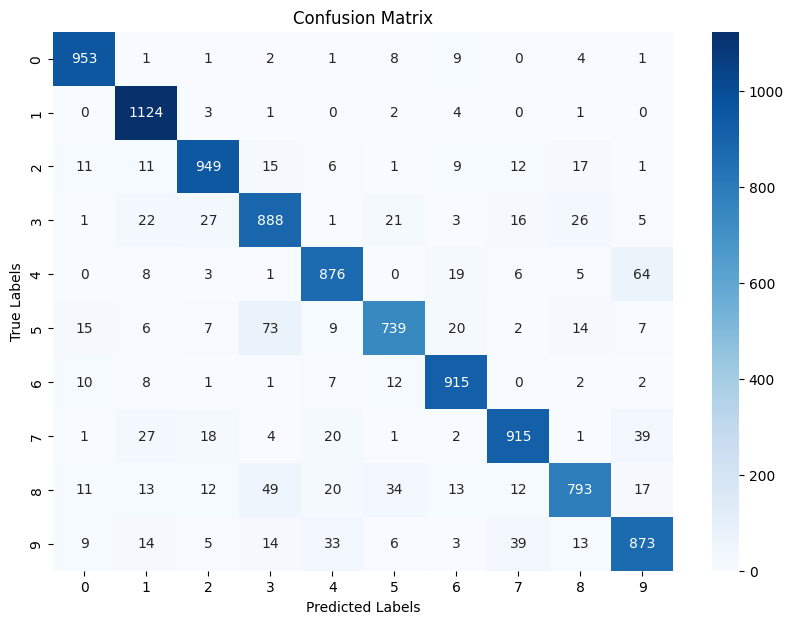

Accuracy: 90.25%
Precision: 90.25%
Recall: 90.25%
F1 Score: 90.18%


In [ ]:
# Train the Random Forest model with specified parameters
rf = RandomForest(n_trees=20, max_depth=15, max_features="sqrt")
rf.fit(X_train, y_train)  # Train the model on the training data

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100  # Overall accuracy
    precision = precision_score(y_true, y_pred, average='weighted') * 100  # Precision (weighted)
    recall = recall_score(y_true, y_pred, average='weighted') * 100  # Recall (weighted)
    f1 = f1_score(y_true, y_pred, average='weighted') * 100  # F1 score

    # Print performance metrics
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

# Display classification report for per-class performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))  # Visual representation
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Evaluate the model
evaluate_model(y_test, y_pred)


##**Accuracy :**

**Accuracy**
=
Correct Predictions
Total Predictions
Accuracy=
Total Predictions
Correct Predictions
​

##**Precision (Weighted) :**

Precision
=
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑃
Precision=
TP+FP
TP
​

##**Recall (Weighted) :**

Recall
=
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
Recall=
TP+FN
TP
​

**F1-Score :** Harmonic mean of precision and recall.



##**ROC Curve :**

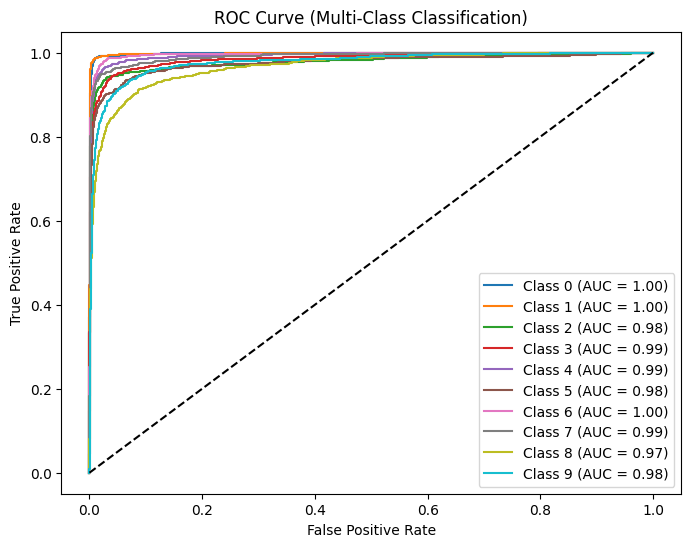

In [ ]:
# Convert labels to one-hot encoding for multi-class classification
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_bin.shape[1]  # Number of unique classes

# Train a One-vs-Rest Logistic Regression model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train_bin)  # Train the model

# Get predicted probabilities for each class
y_score = clf.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])  # Compute FPR and TPR
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])  # Compute AUC
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")  # Plot ROC curve

# Plot a diagonal reference line (random guessing)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class)")
plt.legend()
plt.show()




ROC Curve : The receiver operating characteristic (ROC) curve is plotted to evaluate the model's performance across different thresholds.

##**Overall Accuracy :**

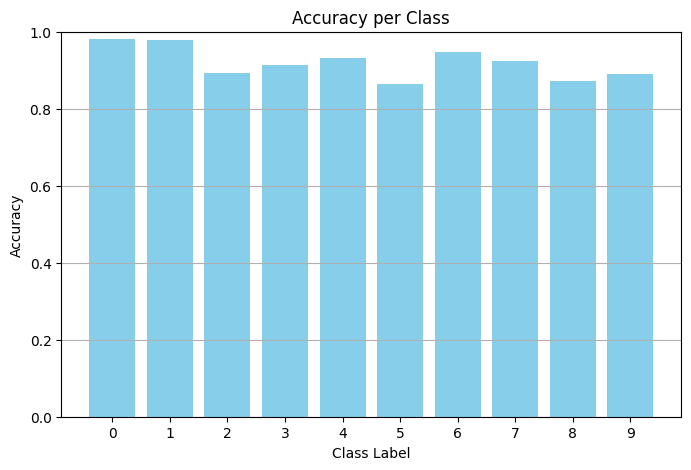

In [ ]:
# Train One-vs-Rest Logistic Regression model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

# Get predictions for the test set
y_pred = clf.predict(X_test)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute Accuracy per Class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracy = np.nan_to_num(class_accuracy)

# Plot Accuracy per Class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_accuracy)), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(len(class_accuracy)))
plt.grid(axis="y")
plt.show()


##**Sample Predictions Visualization :**

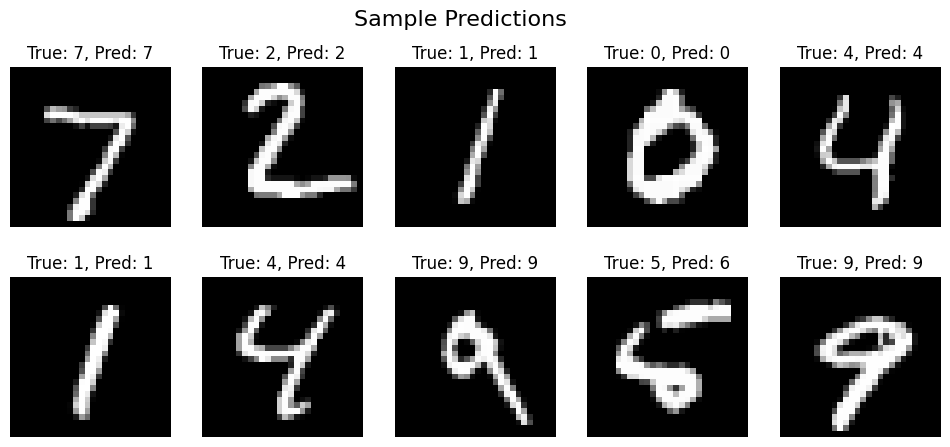

In [ ]:
# Train the model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

# Get predictions
y_pred = clf.predict(X_test)

# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()
